In [1]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as px

In [2]:
!pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (5.1.0)


In [3]:
!python -m spacy download el_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('el_core_news_sm')


In [4]:
import pandas as pd
import numpy as np 
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
full_tweets_df =pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/vaccination_tweets.tsv", sep='\t')

ΑΝΑΛΥΣΗ TWEETS ΧΡΗΣΤΩΝ ΜΕ ΤΟ (#) ΕΜΒΟΛΙΑΣΜΟΣ

In [7]:
full_tweets_df.head()

,Unnamed: 0,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities,withheld_in_countries
0,0,Sun Jul 04 16:03:13 +0000 2021,1411717243273109504,1411717243273109504,"RT @_AnnaKonda_: Τελικά,ότι ""έξυπνο"" μέτρο εφά...",False,"{'hashtags': [{'text': 'Μητσοτακη_καθαρμα', 'i...","{'iso_language_code': 'el', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,NaN,"{'id': 940100095, 'id_str': '940100095', 'name...",NaN,NaN,NaN,NaN,{'created_at': 'Sun Jul 04 06:31:51 +0000 2021...,False,21,0,False,False,el,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jul 04 16:02:55 +0000 2021,1411717166882299904,1411717166882299904,"RT @eddie_souranis: ""Καταδρομικός εμβολιασμός""...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'el', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,NaN,"{'id': 1188880507330813952, 'id_str': '1188880...",NaN,NaN,NaN,NaN,{'created_at': 'Sun Jul 04 12:22:27 +0000 2021...,False,30,0,False,False,el,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jul 04 16:02:53 +0000 2021,1411717158569222152,1411717158569222152,αφου δεν μπορουν/θελουν να κανουν καμπανια-με ...,True,"{'hashtags': [{'text': 'εμβολια', 'indices': [...","{'iso_language_code': 'el', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,NaN,"{'id': 1088823123972186112, 'id_str': '1088823...",NaN,NaN,NaN,NaN,NaN,False,0,0,False,False,el,False,NaN,NaN,NaN,NaN,NaN
3,3,Sun Jul 04 16:00:52 +0000 2021,1411716649703587840,1411716649703587840,RT @PGPavlos: Ο εμβολιασμός δεν είναι υποχρέωσ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'el', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,NaN,"{'id': 946436757335224321, 'id_str': '94643675...",NaN,NaN,NaN,NaN,{'created_at': 'Sun Jul 04 10:41:50 +0000 2021...,False,20,0,False,False,el,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Sun Jul 04 16:00:25 +0000 2021,1411716538160365575,1411716538160365575,RT @domesticus_pf: Πριν από λίγο ρίξαμε το πρώ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'el', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,NaN,"{'id': 303584790, 'id_str': '303584790', 'name...",NaN,NaN,NaN,NaN,{'created_at': 'Sun Jul 04 07:23:15 +0000 2021...,False,64,0,False,False,el,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Φτιάχνουμε ένα μικρότερο dataframe
short_tweets = full_tweets_df[['created_at','text' ]]


In [9]:
#Αλλάζούμε όνομα σε στήλη
short_tweets = short_tweets.rename(columns={'created_at': 'date'} )

In [10]:
short_tweets.head()

,date,text
0,Sun Jul 04 16:03:13 +0000 2021,"RT @_AnnaKonda_: Τελικά,ότι ""έξυπνο"" μέτρο εφά..."
1,Sun Jul 04 16:02:55 +0000 2021,"RT @eddie_souranis: ""Καταδρομικός εμβολιασμός""..."
2,Sun Jul 04 16:02:53 +0000 2021,αφου δεν μπορουν/θελουν να κανουν καμπανια-με ...
3,Sun Jul 04 16:00:52 +0000 2021,RT @PGPavlos: Ο εμβολιασμός δεν είναι υποχρέωσ...
4,Sun Jul 04 16:00:25 +0000 2021,RT @domesticus_pf: Πριν από λίγο ρίξαμε το πρώ...


In [11]:
short_tweets.dtypes

date    object
text    object
dtype: object

In [12]:
#Βγάζουμε τα retweets καθώς θέλουμε μόνο τα tweets που έχουν κάνει οι χρήστες σχετικά με το θέμα του εμβολιασμού
short_tweets= short_tweets[~short_tweets.text.str.startswith('RT')]

In [13]:
#Φτιάχνουμε το index
short_tweets.reset_index(drop=True, inplace=True)

In [14]:
#Μετατρέπουμε το string της ημερομηνίας σε datetime 
short_tweets['date'] = pd.to_datetime(short_tweets['date'], format='%a %b %d %H:%M:%S +0000 %Y')


In [15]:
short_tweets.dtypes

date    datetime64[ns]
text            object
dtype: object

In [16]:
#Φτιάχνουμε καινούργιες στήλες (μήνα,μέρα,χρονιά)
short_tweets['year'] = pd.DatetimeIndex(short_tweets['date']).year
short_tweets['month'] = pd.DatetimeIndex(short_tweets['date']).month
short_tweets['day'] = pd.DatetimeIndex(short_tweets['date']).day


In [17]:
#Βγάζουμε τα Links
short_tweets['text'] = short_tweets['text'].str.replace(r'https?:\/\/.*[\r\n]*'," ")

In [18]:
#Ανάλυση χαρακτηριστικών του κείμενου
#words count
short_tweets['word_count'] = short_tweets['text'].apply(lambda x: len(str(x).split(" "))) 

#number of characters
short_tweets['char_count'] = short_tweets['text'].str.len()  

#number of special characters
short_tweets['hastags'] = short_tweets['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')])) 

#number of numerics
short_tweets['numerics'] = short_tweets['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

#number of uppercase words
short_tweets['upper'] = short_tweets['text'].apply(lambda x: len([x for x in x.split() if x.isupper()])) 

In [19]:
short_tweets

,date,text,year,month,day,word_count,char_count,hastags,numerics,upper
0,2021-07-04 16:02:53,αφου δεν μπορουν/θελουν να κανουν καμπανια-με ...,2021,7,4,21,118,1,0,0
1,2021-07-04 15:59:16,"Απο δείγμα 131 καρκινοπαθών, το 94% ανέπτυξε α...",2021,7,4,19,118,2,1,0
2,2021-07-04 15:57:49,Μετάλλαξη Δέλτα: ''Είναι 100% πιο μεταδοτική α...,2021,7,4,17,113,2,0,1
3,2021-07-04 15:57:18,Κορωνοϊός – Τούντας: «Δρομολόγια και συρμοί μό...,2021,7,4,18,118,0,0,0
4,2021-07-04 15:56:58,ΑΨΕΚΑΣΤΕΣ ΟΙΚΟΓΕΝΕΙΕΣ.\nΜΟΝΟ ΤΑ ΠΑΙΔΙΆ ΤΟΥΣ ΛΥ...,2021,7,4,10,114,4,0,8
...,...,...,...,...,...,...,...,...,...,...
1248,2021-07-02 21:36:39,@Kallkall14 @RedfieldRex @tzeni1991 @stathisdr...,2021,7,2,16,118,0,0,0
1249,2021-07-02 21:35:51,@kmitsotakis Κούλη το ξέρεις ότι αν καταθέσει ...,2021,7,2,21,117,0,0,0
1250,2021-07-02 21:34:32,και οποιος επιασεν επιασεν...πριν 30 χρόνια\n...,2021,7,2,9,91,3,1,0
1251,2021-07-02 21:34:10,Μπορεί να μου πει εξηγήσει κάποιος γιατί δεν κ...,2021,7,2,20,118,0,0,0


In [20]:
nlp = spacy.load('el_core_news_sm')

In [21]:
#φτιάχνουμε μια λίστα με λέξεις και άρθρα που θέλουμε να βγάλουμε από το κείμενο μας
stop_list = ['του', 'σας' 'της', 'λέω', 'και', 'για', 'την' ,'η','έχουν','να','εμβολια','ο', 
             'το', 'με', 'amp', 'στο', 'είχαν','είμαστε','στην','τη','των','τον','χωρίς',
             'από','τη', 'στον','τις','τα','σε','που','ότι','δεν',
             'στη','είναι','αυτή,','στις','οι','στα','τους','στις','στα','αυτό','μου','της',
             'σου', 'μόνο', 'μας', 'μια', 'πως', 'έχει', 'ήταν', 'χωρίς', 'στους', 'αλλά', 'όταν', 
             'ένα', 'εδώ', 'αυτή', 'γιατί', 'έναν', 'κάνει', 'ο', 'h', 'πιο', 'πώς', 'ως', 'o',
             'όπου', 'to', 'η', 'κάθε', 'for', 'έως', 'in', 'ε', 'μία', 'λέω', 'εχω', 'α', 
             'λίγο', 'πολύ', 'πολλά', 'new', 'είδη', 'το', 'ή', 'ειδών', 'on', 'and', 'σας', 'μέχρι',
             'το', 'αύριο', 'όλους', 'τώρα', 'ώρα', 'vodafone', 'συμβαίνει', 'ευχαρισύμε', 'photo','ευρύτερη', 'γτκ', 'το μήνα',
             'aldama', 'δ', 'λες', 'έρχομαι', 'πόσο','δύο', 'ν', 'π', 'σ','μ', 'ποιός', 'κάνω', 'και', 'ετή', 'τρόπος', 'λένε', 'τ', 'απο', 'ρε', 'οτι', 'ειναι',
             'λέω', 'κ', '_']

In [22]:
greekstopwords = list(nlp.Defaults.stop_words)

In [23]:
greekstopwords.extend(stop_list)

In [24]:
#Καθαρισμός των tweets
clean_tweets = []
for tweet in short_tweets['text']:
    tweet = re.sub("@[A-Za-z0-9]+","",tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'\s+', ' ',tweet, flags=re.I)
    tweet = tweet.lower() 
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    tweet = re.sub(r'\W', ' ', tweet)    
     #Remove @ sign
    ##Here's where all the cleaning takes place
    clean_tweets.append(tweet)
short_tweets['clean_tweets'] = clean_tweets
#trump_df.to_csv('') #Specify location

In [25]:
#Βγάζουμε τα stopwords από το κείμενο που έχουμε καθαρίσει
short_tweets['clean_tweets'] = short_tweets['clean_tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in (greekstopwords)]))

In [26]:
text = short_tweets['clean_tweets'].str.cat(sep = ' ').replace("gr", ' ')

In [27]:
#Ας βρούμε για καθε λέξη που βρίσκεται σε διαφορετικές πτώσεις στην ονομαστική, και τα ρήματα στο 1ο πρόσωπο...
doc = nlp(short_tweets['clean_tweets'][1])

In [28]:
for token in doc:
    print(token, token.lemma_)

δείγμα δείγμα
καρκινοπαθών καρκινοπαθός
ανέπτυξε ανέπτυξε
αντισώματα αντισώματας
κορονοϊού κορονοϊός
εμβολίου εμβολίο
εμβολιασμος εμβολιασμος


In [29]:
' '.join(token.lemma_ for token in doc)

'δείγμα καρκινοπαθός ανέπτυξε αντισώματας κορονοϊός εμβολίο εμβολιασμος'

In [30]:
full_doc = nlp(text)

In [31]:
clear_text = ' '.join(token.lemma_ for token in full_doc)

In [32]:
#Αντικαθιστώ κάποιες λέξεις στο κείμενο για ένα καλύτερο αποτέλεσμα στο worldcloud
clear_text = clear_text.replace('εμβολιασμός', 'εμβολιασμος')
clear_text = clear_text.replace('εφήβο', 'εφηβος')
clear_text = clear_text.replace('κρουσματο', 'κρουσματα')
clear_text = clear_text.replace('εμβολιασμένος', 'εμβολιασμενος')
clear_text = clear_text.replace('εμβόλιο', 'εμβολιο')
clear_text = clear_text.replace('_', '')
clear_text = clear_text.replace('εμβολιασμό', 'εμβολιασμος')
clear_text = clear_text.replace('κορονοιος', 'κορωνοιος')

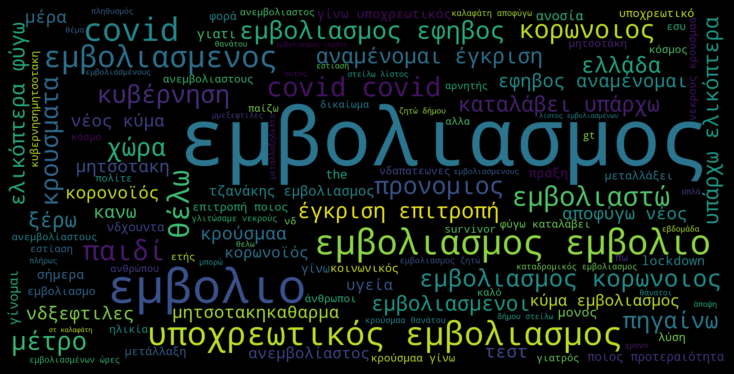

In [33]:
wordcloud = WordCloud(
    stopwords = greekstopwords,
    width = 2000,
    height = 1000,
    background_color = 'black',
    max_words=120
 ).generate(clear_text)
fig = plt.figure(
    figsize = (30, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

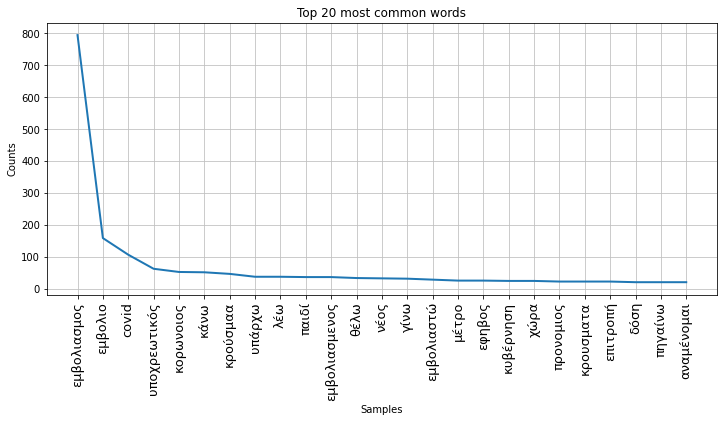

In [34]:
# 20 most common words 
from collections import Counter

all_words = []
for line in list([clear_text]):                      
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
Counter(all_words).most_common(20)

import nltk 
plt.figure(figsize=(12,5))
plt.title('Top 20 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

*Vectorization*

In [35]:
#Βγάζω τους τόνους για ένα καλύτερο αποτέλεσμα
short_tweets['clean_tweets']= short_tweets['clean_tweets'].str.replace('ά','α').str.replace("έ", "ε").str.replace('ή','η').str.replace('ί','ι').str.replace('ό','ο').str.replace('ύ','υ').str.replace('ώ','ω')


In [36]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [37]:
#Διανυσματοποιεί τις λέξεις και το μιν και μαχ σημαίνει - σπανιότητα κάθε λέξης
cv = CountVectorizer(stop_words= greekstopwords, min_df=0.01, max_df=0.95) 

In [38]:
count_vector = cv.fit_transform(short_tweets['clean_tweets'])
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 
results.head()


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['μήνα'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,covid,covid_,covidgr,pfizer,αναμενεται,ανεμβολιαστοι,ανεμβολιαστους,αποφυγουμε,γιατι,γινει,δελτα,δοση,εγκριση,ελικοπτερα,ελλαδα,εμβολιασμενοι,εμβολιασμενους,εμβολιασμενων,εμβολιασμο,εμβολιασμοι,εμβολιασμος,εμβολιασμου,εμβολιαστει,εμβολιαστουν,εμβολιο,επιτροπης,εστιαση,ετων,εφηβων,θανατους,θελουν,καλαφατης,κανετε,κανουμε,κανουν,καταλαβει,κι,κορονοιος,κορονοϊος,κορωνοιος,κορωνοϊος,κρουσματα,κυβερνηση,κυμα,λεει,μεταλλαξη,μεταλλαξη_δελτα,μετρα,μητσοτακη_καθαρμα,μητσοτακης,μμε_ξεφτιλες,νδ_ξεφτιλες,νδ_χουντα,νεκρους,νεο,παει,παιδια,πραξη,προνομια,σημερα,τεστ,τζανακης,υπαρχει,υπαρχουν,υποχρεωτικος,φυγετε,χωρα,ωρες
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [39]:
from html import unescape
def my_tokenizer(doc):
            
    # apply the preprocessing and tokenzation steps
    doc_clean = unescape(doc).lower()
    tokens = nlp(doc_clean)
    lemmatized_tokens = [token.lemma_ for token in tokens if (len(str(token.lemma_))>2)]
            
    # use CountVectorizer's _word_ngrams built in method
    # to remove stop words and extract n-grams
    return(lemmatized_tokens)

In [40]:
 cv = CountVectorizer(stop_words= greekstopwords, min_df=0.01, max_df=0.95, tokenizer=my_tokenizer)
 count_vector = cv.fit_transform(short_tweets['clean_tweets'])
 results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 
 results.head()


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['έγκαιρος', 'έκασ', 'έξαφνος', 'έτερου', 'ίσιος', 'αδιάκοπας', 'αλλιώτικας', 'αλλοιώτικας', 'αφότο', 'βεβαιότατας', 'γρήγορο', 'δίχω', 'εαυτής', 'ειδός', 'εκάστο', 'εμβολιο', 'ετού', 'ευθύ', 'ευρός', 'εχτή', 'ιδίο', 'καθενό', 'κανενό', 'μέλλομαι', 'μήνας', 'μεμιά', 'μερικού', 'μερικός', 'μπορώ', 'μόνα', 'ολωσδιόλο', 'ολόγυρο', 'ορισμένος', 'ορισμένω', 'ποί', 'ποιή', 'ποιώ', 'πολλός', 'προχθή', 'προχτά', 'πόσα', 'σαςτη', 'σει', 'στος', 'συχνά', 'συχνέ', 'ταύ', 'ταύτε', 'ταύτο', 'όποι'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,covid,covidgr,pfizer,αναμενομαι,ανεμβολιαστος,ανεμβολιαστους,αποφυγω,γιατι,γινομαι,γινω,δελτο,δοση,εγκριση,ελικοπτερα,ελλαδα,εμβολιασμενοι,εμβολιασμενος,εμβολιασμενους,εμβολιασμο,εμβολιασμοι,εμβολιασμος,εμβολιαστει,εμβολιαστω,εμβολιο,εστιαση,ετα,ευθυνη,εφηβο,θανατος,θελω,καλαφατη,κανω,καταλαβει,κορονοιος,κορονοϊο,κορωνοιο,κορωνοιος,κορωνοϊο,κοσμος,κρουσματο,κυβερνηση,κυμο,λεει,μεταλλαξη,μετρο,μητσοτακη,νδ_ξεφτιλες,νεος,ξερω,παει,παιδιος,ποιος,πραξη,προνομιος,τεστ,υπαρχω,υποχρεωτικο,φυγω,χωρο
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [41]:
 #Βρίσκω τις 20 πιο συχνές λέξεις
 cv = CountVectorizer( stop_words= greekstopwords, max_features=20)
 count_vector = cv.fit_transform(short_tweets['clean_tweets'])
 results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 
 results.head()


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['μήνα'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,covid,ανεμβολιαστοι,γινει,δοση,ελλαδα,εμβολιασμενοι,εμβολιασμοι,εμβολιασμος,εμβολιο,εφηβων,κανουν,κορωνοιος,κρουσματα,κυβερνηση,μετρα,νδ_ξεφτιλες,παιδια,προνομια,υπαρχουν,υποχρεωτικος
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


In [42]:
results.sum(axis =0).sort_values(ascending = False).head(20)


εμβολιασμος      671
εμβολιο          128
εμβολιασμοι      104
κρουσματα         70
covid             69
υποχρεωτικος      68
εμβολιασμενοι     45
κορωνοιος         38
προνομια          32
γινει             28
υπαρχουν          27
ελλαδα            27
παιδια            26
ανεμβολιαστοι     26
εφηβων            26
κυβερνηση         24
κανουν            24
δοση              24
μετρα             23
νδ_ξεφτιλες       22
dtype: int64

In [43]:
#Φτιάχνουμe ένα νέο dataframe για να βρούμε τις πιο συχνές λέξεις και να το επεξεργαστούμε όπως θέλουμε 
commonwords = short_tweets['clean_tweets']
commonwords = pd.DataFrame(commonwords)
commonwords['clean_tweets'] = commonwords['clean_tweets'].str.replace('εμβολιο','εμβολια') 
commonwords['clean_tweets'] = commonwords['clean_tweets'].str.replace('λεει','')   

In [44]:
#Oι 20 top λέξεις
commonwords['temp_list'] = commonwords['clean_tweets'].apply(lambda x:str(x).split())
top = Counter([item for sublist in commonwords['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,εμβολιασμος,671
1,εμβολια,164
2,εμβολιασμοι,104
3,κρουσματα,70
4,covid,69
5,υποχρεωτικος,68
6,εμβολιασμενοι,45
7,κορωνοιος,38
8,προνομια,32
9,γινει,28


In [45]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words', width=650, height = 600)
fig.show()

In [46]:
cv = CountVectorizer( stop_words= greekstopwords, max_features=22, ngram_range=(2, 2) ) #token_pattern = '\\bκυ[α-ωά-ώ]*\\b') #, tokenizer=my_tokenizer)
count_vector = cv.fit_transform(short_tweets['clean_tweets'])
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 
results.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['μήνα'] not in stop_words.



,covid covidgr,αναμενεται εγκριση,αποφυγουμε νεο,γινει υποχρεωτικος,εγκριση επιτροπης,ελικοπτερα φυγετε,εμβολιασμοι εμβολιασμος,εμβολιασμος covid,εμβολιασμος εμβολιασμοι,εμβολιασμος εμβολιο,εμβολιασμος εφηβων,εμβολιασμος κορωνοιος,εμβολιασμος προνομια,εμβολιο εμβολιασμος,εφηβων αναμενεται,καταλαβει υπαρχουν,κρουσματα γινει,κυμα εμβολιασμος,νεο κυμα,ποιοι προτεραιοτητα,υπαρχουν ελικοπτερα,υποχρεωτικος εμβολιασμος
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [47]:
results = results.drop(columns=['εμβολιασμος εμβολιασμοι', 'εμβολιο εμβολιασμος'], axis=1)

In [48]:
a=results.sum(axis =0).sort_values(ascending = False)
a=pd.DataFrame(a, columns=['number'])
a.reset_index(level=0, inplace=True)
#Αλλάζούμε όνομα σε στήλη
a = a.rename(columns={'index': 'text'} )

Text(0, 0.5, 'Frequency')

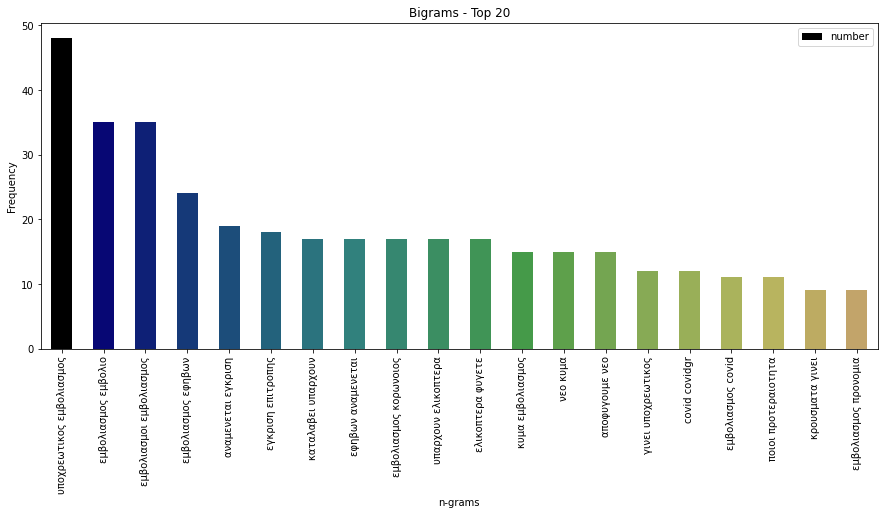

In [49]:
color = plt.cm.gist_earth(np.linspace(0, 1, 25))
a.plot(x='text', y='number', kind='bar', figsize=(15, 6), color = color)
plt.title("Bigrams - Top 20")
plt.xlabel('n-grams')
plt.ylabel('Frequency')

In [50]:
cv = CountVectorizer( stop_words= nlp.Defaults.stop_words, max_features=20, 
                     vocabulary = ['εμβολιο', 'εμβολιασμος']) 
count_vector = cv.fit_transform(short_tweets['clean_tweets'])
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 
results.sum(axis =0).sort_values(ascending = False)

εμβολιασμος    671
εμβολιο        128
dtype: int64

In [51]:
tfidf_vectorizer = TfidfVectorizer(stop_words= greekstopwords, max_features=500)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(short_tweets['clean_tweets'])
results = pd.DataFrame(tfidf_matrix_train.toarray(), columns=tfidf_vectorizer.get_feature_names()) 
results.head() 

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['μήνα'] not in stop_words.



,_a,_aldama,_gr,_voskos,_ευρω,astrazeneca,capital,cdc,coming,covid,covid_,covid_gr,covidgr,covidgreece,euro,gt,hellas,is,johnsonandjohnson,larissapress,lockdown,moderna,mrna,of,pandemic,pass,pfizer,rapid,self,survivorgr,test,the,vs,who,αγελης,ακομα,αληθεια,αλλα,αλληλεγγυης,αλλο,...,υγειονομικους,υπαρχει,υπαρχουν,υπερ,υποχρεωσεις,υποχρεωση,υποχρεωτικο,υποχρεωτικος,φαινεται,φαρμακο,φθινοπωρο,φιλος,φορα,φορες,φυγετε,φυσικα,φως,χαχαχα,χθες,χουντα,χρειαζεται,χρεος,χρονη,χρονια,χρονο,χρονος,χρουσος,χωρα,χωρας,χωρες,χωρις,χωρους,ψεκ,ψεκασμενοι,ψεκασμενος,ψεκασμενους,ψεκες,ψεκια,ψηφισμα,ωρες
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.328299,0.0,0.0,0.451329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.498348,0.0,0.0,0.487595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
from sklearn.metrics.pairwise import cosine_similarity

print("cosine scores ==> ",cosine_similarity(tfidf_matrix_train[0:1], tfidf_matrix_train))  #here the first element of tfidf_matrix_train is matched with other three elements

cosine scores ==>  [[1. 0. 0. ... 0. 0. 0.]]


In [53]:
arr = cosine_similarity(tfidf_matrix_train, tfidf_matrix_train)

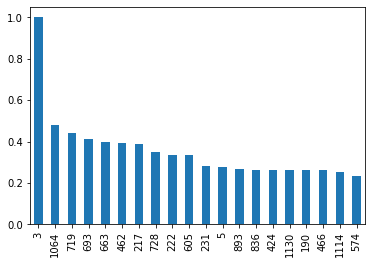

In [54]:
pd.DataFrame(arr).loc[3].sort_values(ascending = False).head(20).plot(kind = 'bar')

In [55]:
short_tweets['text'].loc[3]

'Κορωνοϊός – Τούντας: «Δρομολόγια και συρμοί μόνο για εμβολιασμένους και rapid test για τους ανεμβολίαστους εργαζόμε…  '

In [56]:
short_tweets['text'].loc[190]

'Τι προβλέπεται για τα self test στον ιδιωτικό τομέα για τον Ιούλιο\n\n #εμβολιασμος…  '

In [57]:
filepath = "https://raw.githubusercontent.com/datajour-gr/Data_journalism/master/week10/NRC_GREEK_Translated_6_2020.csv"
emolex_df = pd.read_csv(filepath)
emolex_df.head()

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,αφεση,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ενορκη βεβαιωση,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,εχοντας,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,εχω,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,οριο,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
emolex_df = emolex_df.drop_duplicates(subset=['word'])
emolex_df = emolex_df.dropna()
emolex_df.reset_index(inplace = True)

In [59]:
vec = CountVectorizer(analyzer = 'word', vocabulary = emolex_df.word, 
                      strip_accents = 'unicode',  
                      stop_words= greekstopwords,
                      ngram_range=(1, 2))

In [60]:
# Θέλω να ελέγξω μόνο τις λέξεις που υπάρχουν στο συναισθηματικό λεξικό
matrix = vec.fit_transform(short_tweets['clean_tweets'])
vocab = vec.get_feature_names()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['αδιακοπα', 'ακομα', 'ακομη', 'ακριβως', 'αλλα', 'αλλαχου', 'αλλες', 'αλλη', 'αλλην', 'αλλης', 'αλλιως', 'αλλιωτικα', 'αλλο', 'αλλοι', 'αλλοιως', 'αλλοιωτικα', 'αλλον', 'αλλος', 'αλλοτε', 'αλλου', 'αλλους', 'αλλων', 'αμα', 'αμεσα', 'αμεσως', 'ανα', 'αναμεσα', 'αναμεταξυ', 'ανευ', 'αντι', 'αντιπερα', 'αντις', 'ανω', 'ανωτερω', 'αξαφνα', 'απεναντι', 'αποψε', 'αρα', 'αραγε', 'αρκετα', 'αρκετες', 'αρχικα', 'αυριο', 'αυτα', 'αυτες', 'αυτη', 'αυτην', 'αυτης', 'αυτο', 'αυτοι', 'αυτον', 'αυτος', 'αυτου', 'αυτους', 'αυτων', 'αφοτου', 'αφου', 'βεβαια', 'βεβαιοτατα', 'γιατι', 'γρηγορα', 'γυρω', 'δεινα', 'δεξια', 'δηθεν', 'δηλαδη', 'διαρκως', 'δικα', 'δικο', 'δικοι', 'δικος', 'δικου', 'δικους', 'διολου', 'διπλα', 'διχως', 'δυο', 'εαν', 'εαυτο', 'εαυτον', 'εαυτου', 'εαυτους', 'εαυτων', 'εγιναν', 'εγινε',

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,αυτοκινητοδρομος,αυγουστος,βερολινο,βικτωρια,βοστωνη,γαμηλιο ταξιδι,γεννηση παιδιου,γαιδαρος,γατα,γερμανος,γιαννης,γνωστοποιηση,γυαλια,διακοπη,διευθυντρια σχολειου,διδυμοι,δεξαμενη,δευτερα παρουσια,δευτερον,δημοκρατια,διαρκεια ζωης,διαδρομη,διαλογισμος,διεθνες,διευθυνσεις,δραμα,εξαρτηση,εξωτερικου χωρου,επικοινωνω,επιπτωσεις,...,καρυδια,ωχρος,ελλειπων,προϊοντα,δικαιολογημενο,ενταλματα,κρεατοελλια,αποτυχημενος,σπαταλω,τροποι,ξεπερασμενο,αδιαβροχος,παντρευομαι,βοτανισμα,χωρις βαρος,παραξενα,καλωσορισατε,κρασπεδο,χελωνι,ηχηρο κτυπημα,απολυτως,πλατυς,ανθρωπινο ον,ανεξελεγκτη πυρκαγια,απροσδοκητα ευρημα,μαραμενο,αλιμονο,επιδεινωνεται,αποσπω βιαια,καρπος του χεριου,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
wordcount_df.shape

(1253, 13161)

In [62]:
# Φτιάξε μια λίστα με angry words
angry_words = emolex_df[emolex_df.Anger == 1]['word']
short_tweets['anger'] = wordcount_df[angry_words].sum(axis=1)

# Φτιάξε μια λίστα με positive words
positive_words = emolex_df[emolex_df.Positive == 1]['word']
short_tweets['positivity'] = wordcount_df[positive_words].sum(axis=1)

# Φτιάξε μια λίστα με sadness words
sadness_words = emolex_df[emolex_df.Sadness == 1]['word']
short_tweets['sadness'] = wordcount_df[sadness_words].sum(axis=1)

# Φτιάξε μια λίστα με surprise words
surprise_words = emolex_df[emolex_df.Surprise == 1]['word']
short_tweets['surprise'] = wordcount_df[surprise_words].sum(axis=1)

# Φτιάξε μια λίστα με disgust words
disgust_words = emolex_df[emolex_df.Disgust == 1]['word']
short_tweets['disgust'] = wordcount_df[disgust_words].sum(axis=1)

# Φτιάξε μια λίστα με anticipation words
anticipation_words = emolex_df[emolex_df.Anticipation == 1]['word']
short_tweets['anticipation'] = wordcount_df[anticipation_words].sum(axis=1)

# Φτιάξε μια λίστα με negative words
negative_words = emolex_df[emolex_df.Negative == 1]['word']
short_tweets['negative'] = wordcount_df[negative_words].sum(axis=1)

# Φτιάξε μια λίστα με joy words
joy_words = emolex_df[emolex_df.Joy == 1]['word']
short_tweets['joy'] = wordcount_df[joy_words].sum(axis=1)

# Φτιάξε μια λίστα με trust words
trust_words = emolex_df[emolex_df.Trust == 1]['word']
short_tweets['trust'] = wordcount_df[trust_words].sum(axis=1)

# Φτιάξε μια λίστα με fear words
fear_words = emolex_df[emolex_df.Fear == 1]['word']
short_tweets['fear'] = wordcount_df[fear_words].sum(axis=1)

In [63]:
#2-3-4 Ιουλίου είναι οι μέρες που ανακοινώθηκαν ότι οι εμβολιασμένοι 18-25 ετών θα πάρουν 150ευρώ και για αυτό υπήρχαν πολλά tweets

In [64]:
short_tweets.set_index('date' , inplace=True)

In [65]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

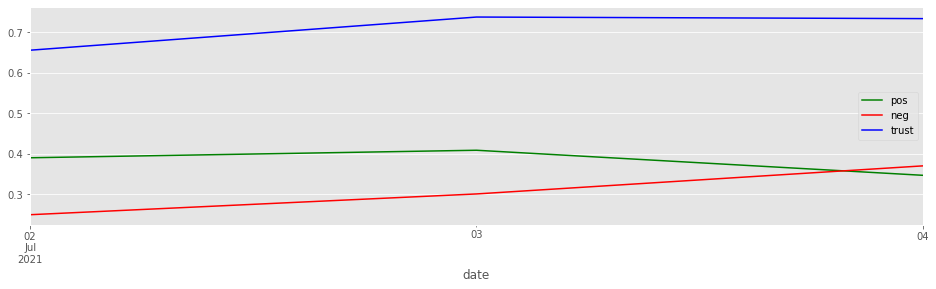

In [66]:
#Τα συναισθήματα positivity,negative,trust ανα μήνα πως διαμορφώθηκαν
ax = short_tweets['positivity'].resample('D').mean().plot(figsize=(16,4), 
                                                          color = 'g', label='pos')
short_tweets['negative'].resample('D').mean().plot(figsize=(16,4), ax = ax, 
                                                   label = 'neg', color = 'r')
short_tweets['trust'].resample('D').mean().plot(figsize=(16,4), ax = ax, 
                                                label = 'trust',color = 'blue').legend()

In [67]:
#Συνολικά τα συναισθήματα που βγάζουν τα κείμενα
short_tweets2 = short_tweets[['anger',	'positivity',	'joy',	'disgust',	'surprise',	'trust',	'anticipation',	'sadness',	'negative',	'fear']]

In [68]:
for tweet in short_tweets2:
  x = short_tweets2[tweet].sum()
  print(x)

129
485
82
95
68
918
798
129
404
190


In [69]:
import plotly.graph_objects as go

labels = ['anger',	'positivity',	'joy',	'disgust',	'surprise',	'trust',	'anticipation',	'sadness',	'negative',	'fear']
values = [129, 485, 82, 95, 68, 918, 798, 129, 404, 190]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.show()